<a href="https://colab.research.google.com/github/ybii22/Machine-Learning/blob/main/week%208%20-%2016/Chapter_3_%E2%80%93_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MNIST**

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

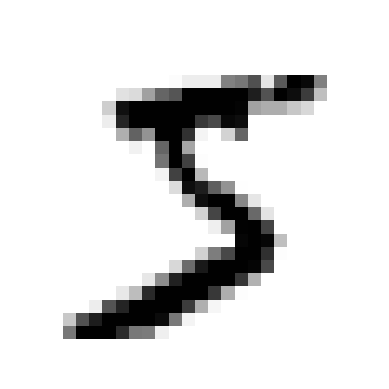

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


In [11]:
y[0]

'5'

In [18]:
import numpy as np
y = y.astype(np.uint8)

In [19]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## **Training a Binary Classifier**

In [20]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [21]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [22]:
sgd_clf.predict([some_digit])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import numpy as np

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)

    # X_train assumed to be DataFrame → use .iloc
    X_train_folds = X_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]

    # y_train_5 is ndarray → use standard indexing
    y_train_folds = y_train_5[train_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = np.sum(y_pred == y_test_fold)
    print("Akurasi fold:", n_correct / len(y_pred))

Akurasi fold: 0.9669
Akurasi fold: 0.91625
Akurasi fold: 0.96785


In [28]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [30]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [31]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## **Confusion Matrix**

In [32]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [34]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [35]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [36]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

In [37]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [38]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [39]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [40]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [41]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                              method="decision_function")

In [42]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

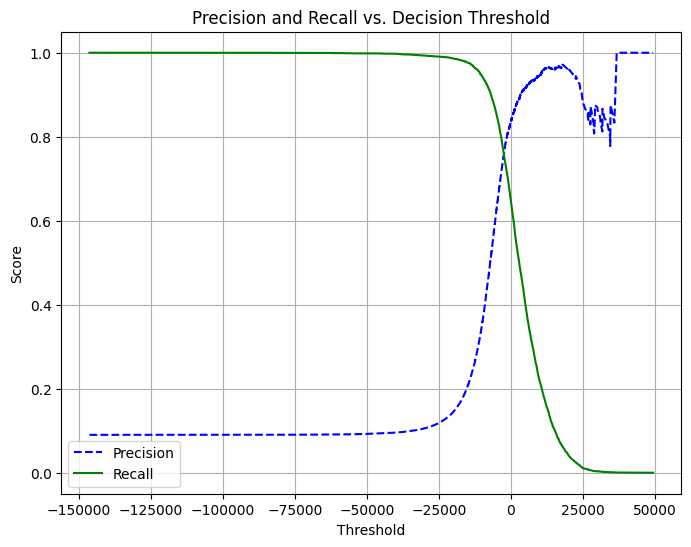

In [44]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 6))

    # Garis precision dan recall terhadap threshold
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

    # Label sumbu dan legend
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs. Decision Threshold")
    plt.legend(loc="best")
    plt.grid(True)

# Contoh pemanggilan fungsi (pastikan `precisions`, `recalls`, dan `thresholds` sudah tersedia)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


In [45]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

In [46]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [48]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [49]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [50]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

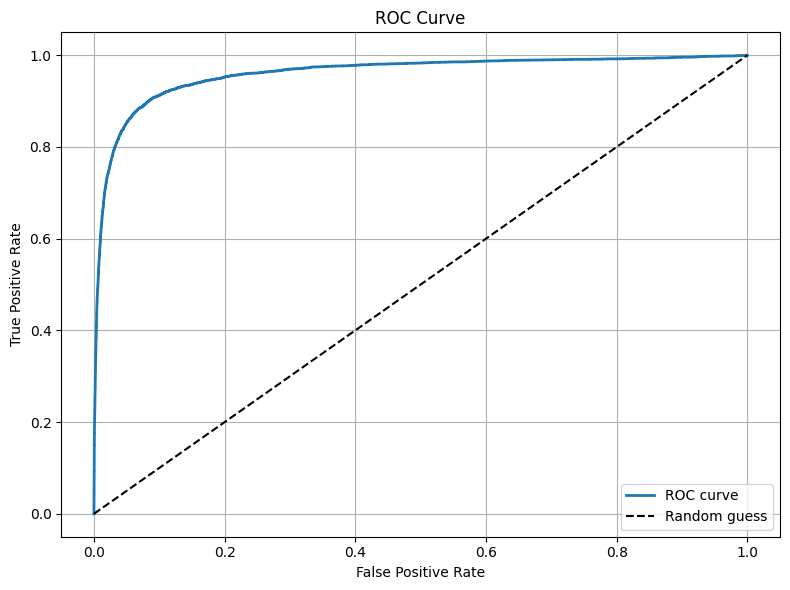

In [52]:
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=label or "ROC curve")
    plt.plot([0, 1], [0, 1], 'k--', label="Random guess")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()

plot_roc_curve(fpr, tpr)
plt.show()


In [53]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [54]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [55]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

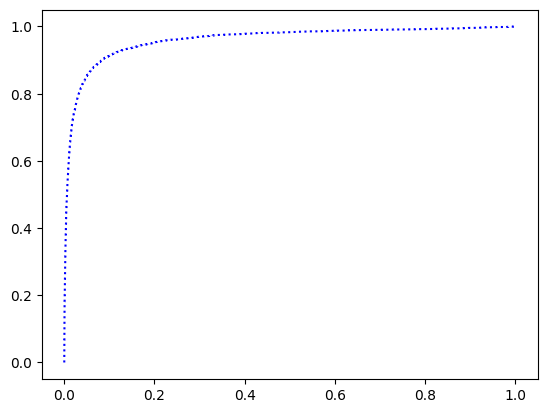

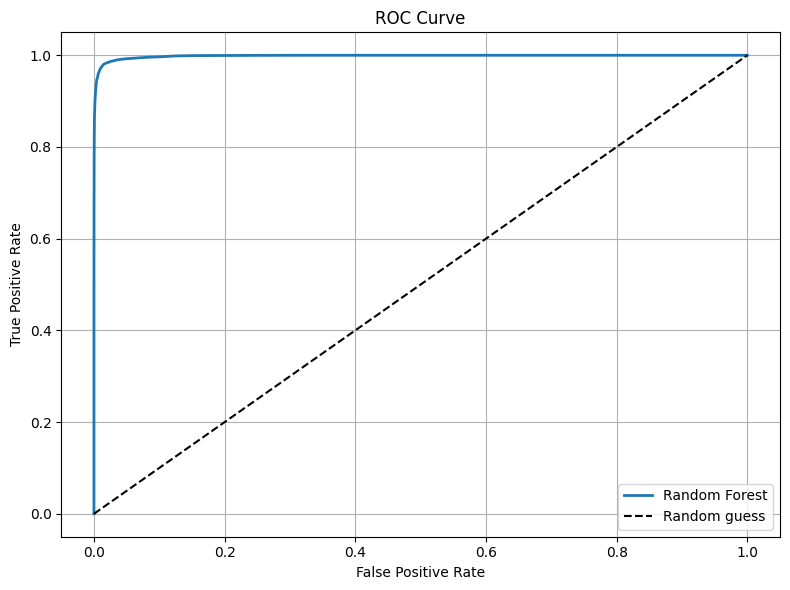

In [56]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [57]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

## **Multiclass Classification**

In [58]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [59]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [60]:
np.argmax(some_digit_scores)

np.int64(5)

In [61]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [62]:
svm_clf.classes_[5]

np.uint8(5)

In [63]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [64]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [65]:
len(ovr_clf.estimators_)

10

In [66]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [67]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [68]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## **Error Analysis**

In [70]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

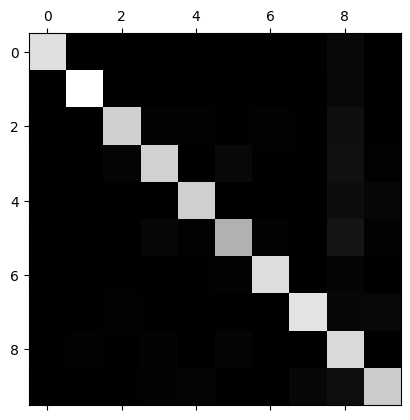

In [71]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [72]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

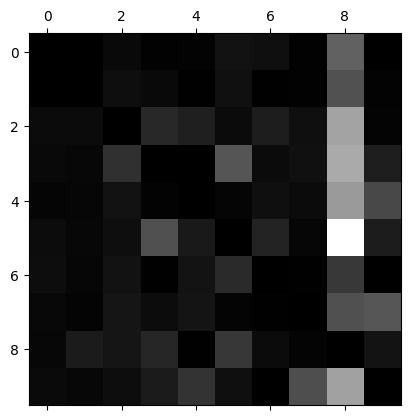

In [73]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [77]:
import matplotlib.pyplot as plt
import numpy as np

def plot_digits(instances, images_per_row=10, **options):
    size = 28  # gambar MNIST 28x28
    images_per_row = min(len(instances), images_per_row)

    # Hitung jumlah baris dan padding jika jumlah gambar tidak habis dibagi
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)

    # Padding dengan nol jika jumlah gambar tidak pas
    padded = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Susun gambar jadi grid
    image_grid = padded.reshape((n_rows, images_per_row, size, size)) \
                       .swapaxes(1, 2).reshape((n_rows * size, images_per_row * size))

    plt.imshow(image_grid, cmap='binary', **options)
    plt.axis("off")


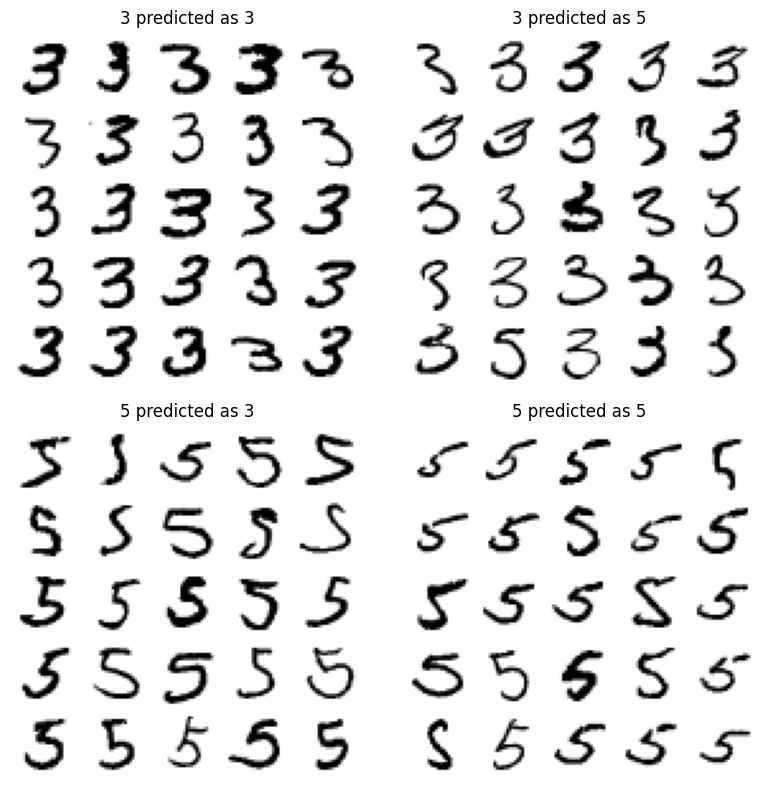

In [78]:
# Misalnya kita ingin membandingkan prediksi antara kelas 3 dan 5
cl_a, cl_b = 3, 5

# Filter data berdasarkan label asli (y_train) dan prediksi (y_train_pred)
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]  # Benar: 3 → 3
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]  # Salah: 3 → 5
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]  # Salah: 5 → 3
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]  # Benar: 5 → 5

# Buat subplot 2x2 untuk memperlihatkan contoh hasil klasifikasi
plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5); plt.title(f"{cl_a} predicted as {cl_a}")
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5); plt.title(f"{cl_a} predicted as {cl_b}")
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5); plt.title(f"{cl_b} predicted as {cl_a}")
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5); plt.title(f"{cl_b} predicted as {cl_b}")
plt.tight_layout()
plt.show()


## **Multilabel Classification**

In [79]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [80]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [81]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

## **Multioutput Classification**

In [82]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [89]:
def plot_digit(data):
    if hasattr(data, "values"):  # kalau Series/DataFrame
        data = data.values
    image = data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    plt.show()


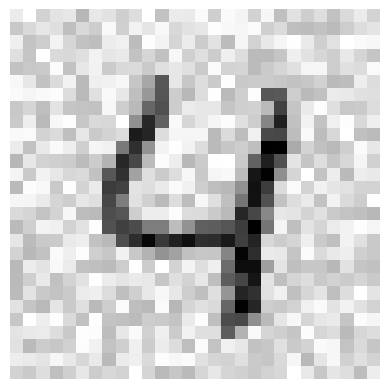

In [96]:
# 1. Cari indeks dari gambar yang berlabel 4
import numpy as np

target_digit = 4
indices_of_4 = np.where(y_test_mod == target_digit)[0]  # ambil indeks dengan label 4
index = indices_of_4[0]  # ambil yang pertama

# 2. Ambil gambar dengan label 4
digit_4 = X_test_mod.iloc[index].values  # atau X_test_mod[index] jika NumPy array

# 3. Fungsi untuk menampilkan gambar digit
import matplotlib.pyplot as plt

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis("off")
    plt.show()

# 4. Tampilkan gambar angka 4
plot_digit(digit_4)


## **Exercise**

1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the KNeighborsClassifier works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters).

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Buat classifier
knn_clf = KNeighborsClassifier()

# Tentukan grid parameter
param_grid = {
    'n_neighbors': [3, 4, 5],
    'weights': ['uniform', 'distance']
}

# Lakukan Grid Search
grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Ambil model terbaik
best_knn = grid_search.best_estimator_

# Evaluasi akurasi pada test set
from sklearn.metrics import accuracy_score
y_pred = best_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Akurasi model terbaik:", accuracy)


Akurasi model terbaik: 0.9714


2. Write a function that can shift an MNIST image in any direction (left, right, up,
or down) by one pixel.5 Then, for each image in the training set, create four shif‐
ted copies (one per direction) and add them to the training set. Finally, train your
best model on this expanded training set and measure its accuracy on the test set.
You should observe that your model performs even better now! This technique of
artificially growing the training set is called data augmentation or training set
expansion.

In [102]:
import numpy as np

def shift_image(image, direction):
    # Ubah ke array float 28x28
    image = np.array(image, dtype=np.float32).reshape(28, 28)

    # Geser sesuai arah
    if direction == 'left':
        shifted = np.roll(image, -1, axis=1)
        shifted[:, -1] = 0
    elif direction == 'right':
        shifted = np.roll(image, 1, axis=1)
        shifted[:, 0] = 0
    elif direction == 'up':
        shifted = np.roll(image, -1, axis=0)
        shifted[-1, :] = 0
    elif direction == 'down':
        shifted = np.roll(image, 1, axis=0)
        shifted[0, :] = 0
    else:
        raise ValueError("Arah tidak dikenal: gunakan 'left', 'right', 'up', 'down'")

    return shifted.reshape(784)


In [104]:
# Pastikan X_train dan y_train dalam bentuk yang benar
X_train = X_train.astype(np.float32).values if hasattr(X_train, 'values') else np.array(X_train, dtype=np.float32)
y_train = np.array(y_train)

# Proses augmentasi
X_train_augmented = []
y_train_augmented = []

for image, label in zip(X_train, y_train):
    X_train_augmented.append(image)
    y_train_augmented.append(label)

    for direction in ['left', 'right', 'up', 'down']:
        shifted_image = shift_image(image, direction)
        X_train_augmented.append(shifted_image)
        y_train_augmented.append(label)

# Ubah hasil ke NumPy array
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

print("Selesai augmentasi. Jumlah data:", len(X_train_augmented))


Selesai augmentasi. Jumlah data: 300000
